In [574]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [575]:
tf.reset_default_graph()
defined = pd.read_csv('TSE_adjusted.csv',usecols=[4]) #[0,1]
inputs = pd.read_csv('TSE_adjusted.csv',usecols=[4,13])

defined=defined.values
inputs=inputs.values
print(inputs.shape)
print(defined.shape)

(1340, 2)
(1340, 1)


In [576]:
inputs=np.array(inputs)
defined=np.array(defined)
print(inputs.shape, inputs)
print(defined.shape)

(1340, 2) [[  7468.22     72.38]
 [  7361.94     70.99]
 [  7391.15     68.12]
 ..., 
 [ 11221.81    130.8 ]
 [ 11076.78    131.78]
 [ 11103.79    130.53]]
(1340, 1)


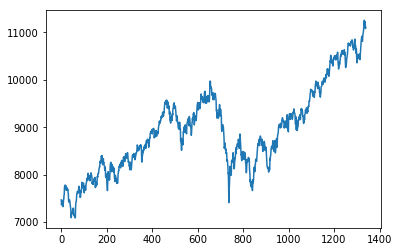

In [577]:
%matplotlib inline
plt.plot(defined)
plt.show()

In [578]:
def create_dataset(dataset, look_back=1,col=1):

    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back+1):
            dataX.append(dataset[i:(i+look_back),:])
            dataY.append(dataset[(i+look_back-1),:])

    return np.array(dataX), np.array(dataY)

### Train and Test sets

In [579]:
#data normalization
scaler = MinMaxScaler(feature_range=(0,1))
defined= scaler.fit_transform(defined)
inputs= scaler.fit_transform(inputs)
look_back=5
col=2

train_size= int(len(defined)*0.8)
test_size= len(defined)-train_size

data, nexto= create_dataset(inputs,look_back,col)


data=data[0:len(data)-1]
nexto=nexto[1:len(nexto)+1]
print('d=', data[0:5], data.shape,'o= ',nexto[1334],nexto.shape)
x_train,x_test= data[0:train_size,:],data[train_size:len(data),:]
print(x_train.shape,x_test.shape)

d= [[[ 0.09117999  0.81296681]
  [ 0.06566025  0.80968138]
  [ 0.0726741   0.8028978 ]
  [ 0.06794137  0.79349059]
  [ 0.07409319  0.78309067]]

 [[ 0.06566025  0.80968138]
  [ 0.0726741   0.8028978 ]
  [ 0.06794137  0.79349059]
  [ 0.07409319  0.78309067]
  [ 0.0869323   0.77408528]]

 [[ 0.0726741   0.8028978 ]
  [ 0.06794137  0.79349059]
  [ 0.07409319  0.78309067]
  [ 0.0869323   0.77408528]
  [ 0.0871292   0.7667817 ]]

 [[ 0.06794137  0.79349059]
  [ 0.07409319  0.78309067]
  [ 0.0869323   0.77408528]
  [ 0.0871292   0.7667817 ]
  [ 0.0669809   0.75787085]]

 [[ 0.07409319  0.78309067]
  [ 0.0869323   0.77408528]
  [ 0.0871292   0.7667817 ]
  [ 0.0669809   0.75787085]
  [ 0.0572033   0.74654912]]] (1335, 5, 2) o=  [ 0.96414559  0.95041127] (1335, 2)
(1072, 5, 2) (263, 5, 2)


In [580]:
## define [0,1][1,0]
def create_updown(dataset):
    dataY=[]
    for i in range (len(dataset)):
        if(i+1)<len(dataset):
            #print(dataset[i+1][0], dataset[i][1])
            a= dataset[i+1][0]-dataset[i][1]
            if np.any(a>0):
                dataY.append([0,1])
            else:
                dataY.append([1,0])
    dataY.append([1,0])
    return np.array(dataY,dtype='float32')

In [581]:
#y_data=create_updown(defined)
#y, y_data= create_dataset(defined,look_back,1)
#print(y_data)
#y_train, y_test= y_data[look_back-1:train_size+4,:],y_data[train_size+4:len(defined),:]
y,y_data=create_dataset(defined,look_back,1)
y_data=y_data[1:len(y_data)+1,:]
y_train, y_test= y_data[0:train_size,:],y_data[train_size:len(nexto),:]

print(y_train.shape, y_test.shape)



(1072, 1) (263, 1)


In [582]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1072, 5, 2) (1072, 1) (263, 5, 2) (263, 1)


In [583]:
#x_train=np.reshape(1072,15)
x_train=np.reshape(x_train, (-1, look_back*col))
x_test=np.reshape(x_test,(-1, look_back*col))
data=np.reshape(data,(-1,look_back*col))
print(x_train.shape, x_test.shape)

(1072, 10) (263, 10)


In [584]:
# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [585]:
def layer(output_dim,input_dim,inputs,activation):
    w=tf.Variable(weight_initializer([input_dim,output_dim]))
    b=tf.Variable(bias_initializer([1,output_dim]))
    xwb=tf.matmul(inputs,w)+b
    if activation is None:
        outputs=xwb
    else:
        outputs=activation(xwb)
    return outputs

In [586]:
x=tf.placeholder("float",[None,look_back*col])
h1=layer(output_dim=80, input_dim=look_back*col, inputs=x, activation=tf.nn.relu)
h2=layer(output_dim=10, input_dim=80, inputs=h1,activation=tf.nn.relu)
y_predict=layer(output_dim=1, input_dim=10, inputs=h2, activation=None)
x.shape

TensorShape([Dimension(None), Dimension(10)])

In [587]:
y_label=tf.placeholder("float",[None,1])
loss_fun=tf.losses.mean_squared_error(y_predict,y_label)
optimizer=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_fun)


In [588]:
#correct_predict=tf.equal(tf.argmax(y_label,1),tf.argmax(y_predict,1))
#accuracy= tf.reduce_mean(tf.cast(correct_predict,"float"))

In [589]:
trainEpochs=500
batchsize=100
loss_train=[];epoch_list=[];accuracy_train=[]
loss_test=[]; accuracy_test=[]
totalbatchs= int(len(data)//batchsize)
from time import time
startTime=time()

sess=tf.Session()
sess.run(tf.global_variables_initializer())

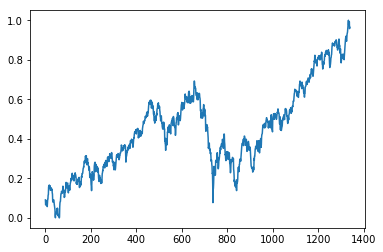

In [590]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(defined)

<IPython.core.display.Javascript object>


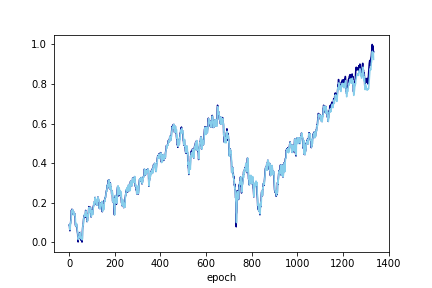

Loss_train=  [0.00024888324]
Loss_test=  [0.00070106477]
Train Finished takes: 35.04159998893738


<IPython.core.display.Javascript object>


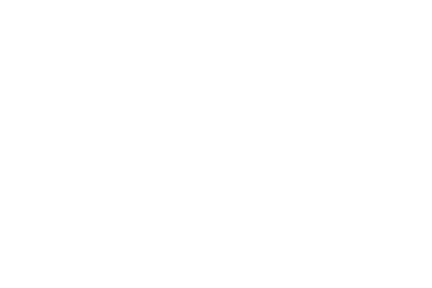

In [591]:
# Setup interactive plot
%matplotlib notebook

fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.xlabel('epoch')
line1, = ax1.plot(y_data ,color='darkblue',label='data')
line2, = ax1.plot(y_data*0.5,color='skyblue',label='predict')
#line2, = ax1.plot(y_train*0.2,color='green')
#line3, = ax1.plot(y_test*0.2,color='red')
plt.ion()
plt.show()

for epoch in range(trainEpochs):
    #shuffle = np.random.permutation(len(y_train)-1)
    #x_train = x_train[shuffle]
    #y_train = y_train[shuffle]
    for i in range(totalbatchs):
        sess.run(optimizer,feed_dict={x:x_train,y_label:y_train})
        
    
    #loss_tra,acc_tra= sess.run([loss_fun, accuracy],feed_dict={x:x_train,y_label:y_train})
    #loss_t,acc_t= sess.run([loss_fun, accuracy],feed_dict={x:x_test,y_label:y_test})
    loss_tra= sess.run([loss_fun],feed_dict={x:x_train,y_label:y_train})
    loss_t= sess.run([loss_fun],feed_dict={x:x_test,y_label:y_test})
    

    epoch_list.append(epoch);
    loss_test.append(loss_t)
    loss_train.append(loss_tra)
    #accuracy_test.append(acc_t)
    #accuracy_train.append(acc_tra)
    if epoch%15==0:
        #train_pred=sess.run(y_predict,feed_dict={x:x_train})
        #line2.set_ydata(train_pred.reshape(-1,1))
        #test_pred=sess.run(y_predict,feed_dict={x:x_test})
        #line3.set_ydata(test_pred.reshape(-1,1))
        test_pred=sess.run(y_predict,feed_dict={x:data})
        line2.set_ydata(test_pred.reshape(-1,1))
        fig.canvas.draw()
   
    #print ("Train Epoch:",'%02d'%(epoch+1),"Loss=","{:.9f}".format(loss),"Accuracy=",acc)

duration=time()-startTime

print("Loss_train= ",loss_tra)
print ("Loss_test= ",loss_t)

#print("Accuracy_train= ", acc_tra)
#print("Accuracy_test= ", acc_t)

print("Train Finished takes:",duration)

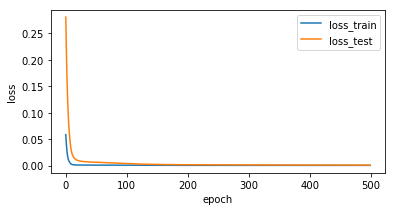

In [592]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.plot(epoch_list,loss_train, label='loss_train')
plt.plot(epoch_list,loss_test, label='loss_test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()